In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from openap import WRAP, aero, FlightPhase, prop, Thrust, FuelFlow
from openap.traj import Generator

In [3]:
ac_type = "A320"
aircraft = prop.aircraft(ac_type)
eng_type = aircraft["engine"]["default"]

In [4]:
trajgen = Generator(ac=ac_type)
wrap = WRAP(ac=ac_type)
wrap.cruise_range(), wrap.cruise_alt(), wrap.cruise_init_alt(), wrap.cruise_mach()

({'default': 856.0,
  'minimum': 487.0,
  'maximum': 4352.0,
  'statmodel': 'gamma',
  'statmodel_params': [1.71, 453.95, 569.12]},
 {'default': 10.92,
  'minimum': 10.0,
  'maximum': 11.84,
  'statmodel': 'norm',
  'statmodel_params': [10.92, 0.56]},
 {'default': 10.82,
  'minimum': 9.79,
  'maximum': 11.85,
  'statmodel': 'norm',
  'statmodel_params': [10.82, 0.63]},
 {'default': 0.78,
  'minimum': 0.75,
  'maximum': 0.8,
  'statmodel': 'beta',
  'statmodel_params': [17.82, 5.05, 0.62, 0.2]})

In [5]:
trajs = []
for i, range_cr in enumerate(
    range(int(wrap.cruise_range()["minimum"]), int(wrap.cruise_range()["maximum"]), 100)
):
    traj = pd.DataFrame.from_dict(
        trajgen.complete(dt=10, range_cr=range_cr * 1e3, random=True)
    ).assign(id=i)
    trajs.append(traj)
#     print(
#         range_cr,
#         round(traj.s.max() / 1e3),
#         round(traj.h.max()),
#     )
trajs = pd.concat(trajs)
trajs.head()

,t,h,s,v,vs,id
0,0,0.0,0.0,0.0,0.0,0
1,10,0.0,0.0,19.3,0.0,0
2,20,0.0,193.0,38.6,0.0,0
3,30,0.0,579.0,57.9,0.0,0
4,40,0.0,1158.0,77.2,0.0,0


In [6]:
ranges = [(id, round(traj.s.max() / 1e3)) for id, traj in trajs.groupby("id")]
ranges = (
    pd.DataFrame.from_records(ranges)
    .rename(columns={0: "id", 1: "range"})
    .sort_values("range")
)
ranges.range.min(), ranges.range.max()

(1012, 4987)

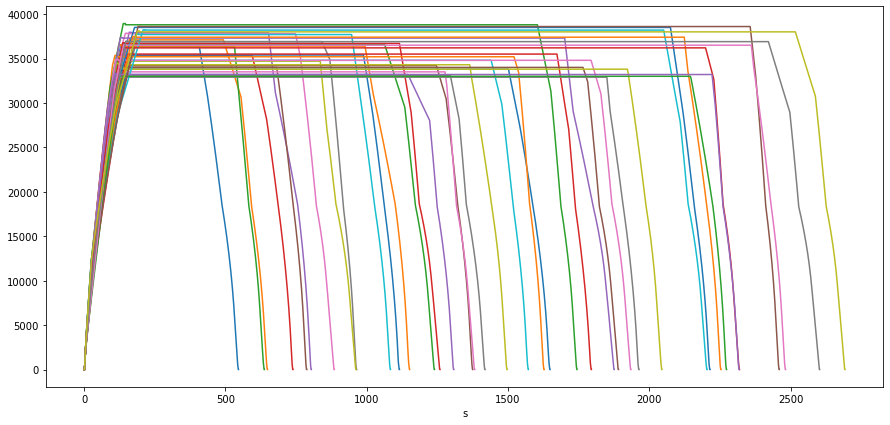

In [7]:
fig, ax = plt.subplots(figsize=(15, 7))
for (_, traj) in trajs.assign(h=trajs.h / aero.ft, s=trajs.s / aero.nm).groupby("id"):
    traj.plot(x="s", y="h", ax=ax, legend=False)

In [8]:
def flight_phase(trajs):
    fp = FlightPhase()
    trajs_fp = []
    for _, traj in trajs.groupby("id"):
        ts = traj["t"].values  # timestamp, int, second
        alt = traj["h"].values / aero.ft  # altitude, int, ft
        spd = traj["v"].values / aero.kts  # speed, int, kts
        roc = traj["vs"].values / aero.fpm  # vertical rate, int, ft/min
        fp.set_trajectory(ts, alt, spd, roc)
        labels = fp.phaselabel()
        traj = traj.assign(fp=labels)
        t_cl = traj.query("fp=='CL'").iloc[0].t
        t_de = traj.query("fp=='DE'").iloc[-1].t
        # print(t_cl, t_de)
        # take_off = traj.query(f"fp=='GND' and t < {t_cl}")
        traj.loc[(traj.fp == "GND") & (traj.t < t_cl), "fp"] = "TO"
        # landing = traj.query(f"fp in {['GND','NA']} and t > {t_de}")
        # traj.loc[(traj.fp == "NA") & (traj.t > t_de), "fp"] = "L"
        trajs_fp.append(traj)
    trajs_fp = pd.concat(trajs_fp)
    return trajs_fp


trajs = flight_phase(trajs)
trajs.head()

,t,h,s,v,vs,id,fp
0,0,0.0,0.0,0.0,0.0,0,TO
1,10,0.0,0.0,19.3,0.0,0,TO
2,20,0.0,193.0,38.6,0.0,0,TO
3,30,0.0,579.0,57.9,0.0,0,TO
4,40,0.0,1158.0,77.2,0.0,0,TO


In [9]:
trajs.query("fp=='TO'")

,t,h,s,v,vs,id,fp
0,0,0.0,0.0,0.0,0.0,0,TO
1,10,0.0,0.0,19.3,0.0,0,TO
2,20,0.0,193.0,38.6,0.0,0,TO
3,30,0.0,579.0,57.9,0.0,0,TO
4,40,0.0,1158.0,77.2,0.0,0,TO
...,...,...,...,...,...,...,...
1,10,0.0,0.0,19.3,0.0,38,TO
2,20,0.0,193.0,38.6,0.0,38,TO
3,30,0.0,579.0,57.9,0.0,38,TO
4,40,0.0,1158.0,77.2,0.0,38,TO


for i, range_cr in enumerate(
    range(int(wrap.cruise_range()["minimum"]), int(wrap.cruise_range()["maximum"]), 100)
):
    traj = trajs.query(f"id=={i}")
    print(
        range_cr,
        round((traj.query("fp=='CR'").s.max() - traj.query("fp=='CR'").s.min()) / 1e3),
    )

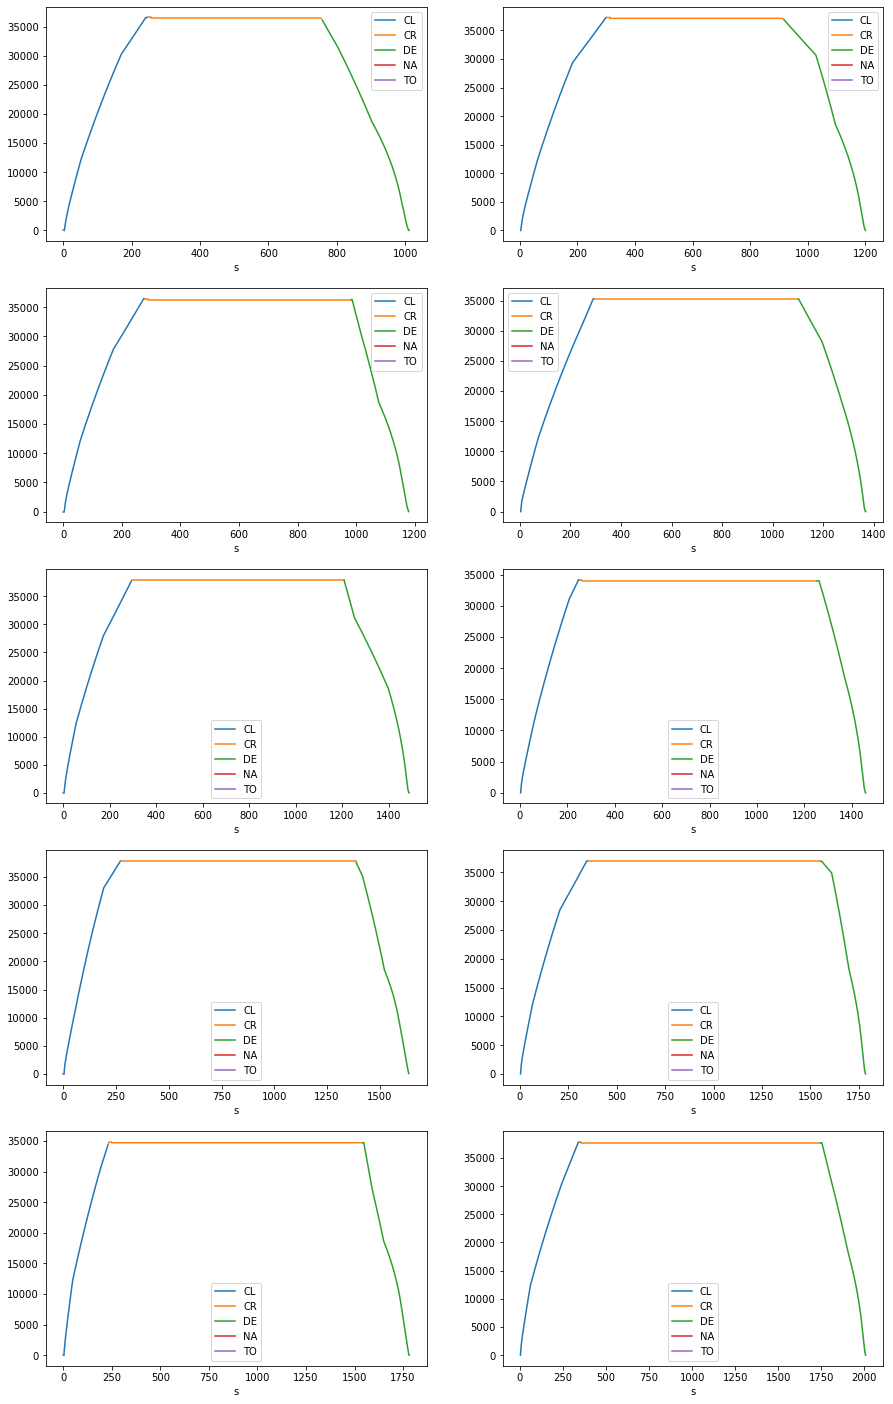

In [10]:
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
for ax, (id, traj) in zip(
    axes.flat, trajs.assign(h=trajs.h / aero.ft, s=trajs.s / 1e3).groupby("id")
):
    for fp, traj_fp in traj.groupby("fp"):
        traj_fp.plot(x="s", y="h", ax=ax, label=fp)

In [11]:
aircraft

{'aircraft': 'Airbus A320',
 'fuselage': {'length': 37.57, 'height': 4.14, 'width': 3.95},
 'wing': {'area': 124, 'span': 35.8, 'mac': 4.29, 'sweep': 25, 't/c': None},
 'flaps': {'type': 'single-slotted', 'area': 21.1, 'bf/b': 0.78},
 'limits': {'MTOW': 78000,
  'MLW': 66000,
  'OEW': 42600,
  'MFC': 24210,
  'VMO': 350,
  'MMO': 0.82,
  'ceiling': 12500},
 'cruise': {'height': 11000, 'mach': 0.78},
 'engine': {'type': 'turbofan',
  'mount': 'wing',
  'number': 2,
  'default': 'CFM56-5B4',
  'options': {'A320-111': 'CFM56-5-A1',
   'A320-211': 'CFM56-5-A1',
   'A320-212': 'CFM56-5A3',
   'A320-214': 'CFM56-5B4',
   'A320-215': 'CFM56-5B5',
   'A320-216': 'CFM56-5B6',
   'A320-231': 'V2500-A1',
   'A320-232': 'V2527-A5',
   'A320-233': 'V2527E-A5'}}}

In [12]:
thrust = Thrust(ac=ac_type, eng=eng_type)


def thr(x):
    v, h, vs = x.v / aero.kts, x.h / aero.ft, x.vs / aero.fpm
    if x.fp == "TO":
        return thrust.takeoff(tas=v, alt=h)
    if x.fp == "CL":
        return thrust.climb(tas=v, alt=h, roc=vs)
    if x.fp == "CR":
        return thrust.cruise(tas=v, alt=h)
    if x.fp == "DE":
        return thrust.descent_idle(tas=v, alt=h)
    return np.NaN


trajs = trajs.assign(thr=lambda x: x.apply(lambda x: thr(x), axis=1))

In [13]:
fuelflow = FuelFlow(ac=ac_type, eng=eng_type)

mass = (
    aircraft["limits"]["OEW"]
    + (aircraft["limits"]["MTOW"] - aircraft["limits"]["OEW"]) * 0.7
)


def ff(x):
    v, h, vs = x.v / aero.kts, x.h / aero.ft, x.vs / aero.fpm
    if x.fp == "TO":
        return fuelflow.takeoff(tas=v, alt=h, throttle=1)
    if x.fp == "CR":
        return fuelflow.enroute(mass=mass, tas=v, alt=h)
    if x.thr == x.thr:
        return fuelflow.at_thrust(acthr=x.thr, alt=h)
    return np.NaN


trajs = trajs.assign(ff=lambda x: x.apply(lambda x: ff(x), axis=1))
trajs

,t,h,s,v,vs,id,fp,thr,ff
0,0,0.0,0.0,0.0,0.0,0,TO,235799.998186,2.337624
1,10,0.0,0.0,19.3,0.0,0,TO,221766.340217,2.161416
2,20,0.0,193.0,38.6,0.0,0,TO,208782.316062,2.007156
3,30,0.0,579.0,57.9,0.0,0,TO,196847.925718,1.872074
4,40,0.0,1158.0,77.2,0.0,0,TO,185963.169187,1.753919
...,...,...,...,...,...,...,...,...,...
2310,23080.0,0.0,4985424.057096,59.8,0.0,38,DE,19990.563450,0.201312
2311,23090.0,0.0,4986022.057096,47.6,0.0,38,DE,21059.163483,0.211754
2312,23100.0,0.0,4986498.057096,35.4,0.0,38,NA,NaN,NaN
2313,23110.0,0.0,4986852.057096,23.2,0.0,38,NA,NaN,NaN


In [16]:
trajs["t"] = trajs["t"].astype("int64")
cols = ["h", "s", "v", "vs", "thr", "ff"]
trajs[cols] = trajs[cols].astype("float")
trajs.dtypes

t        int64
h      float64
s      float64
v      float64
vs     float64
id       int64
fp      object
thr    float64
ff     float64
dtype: object

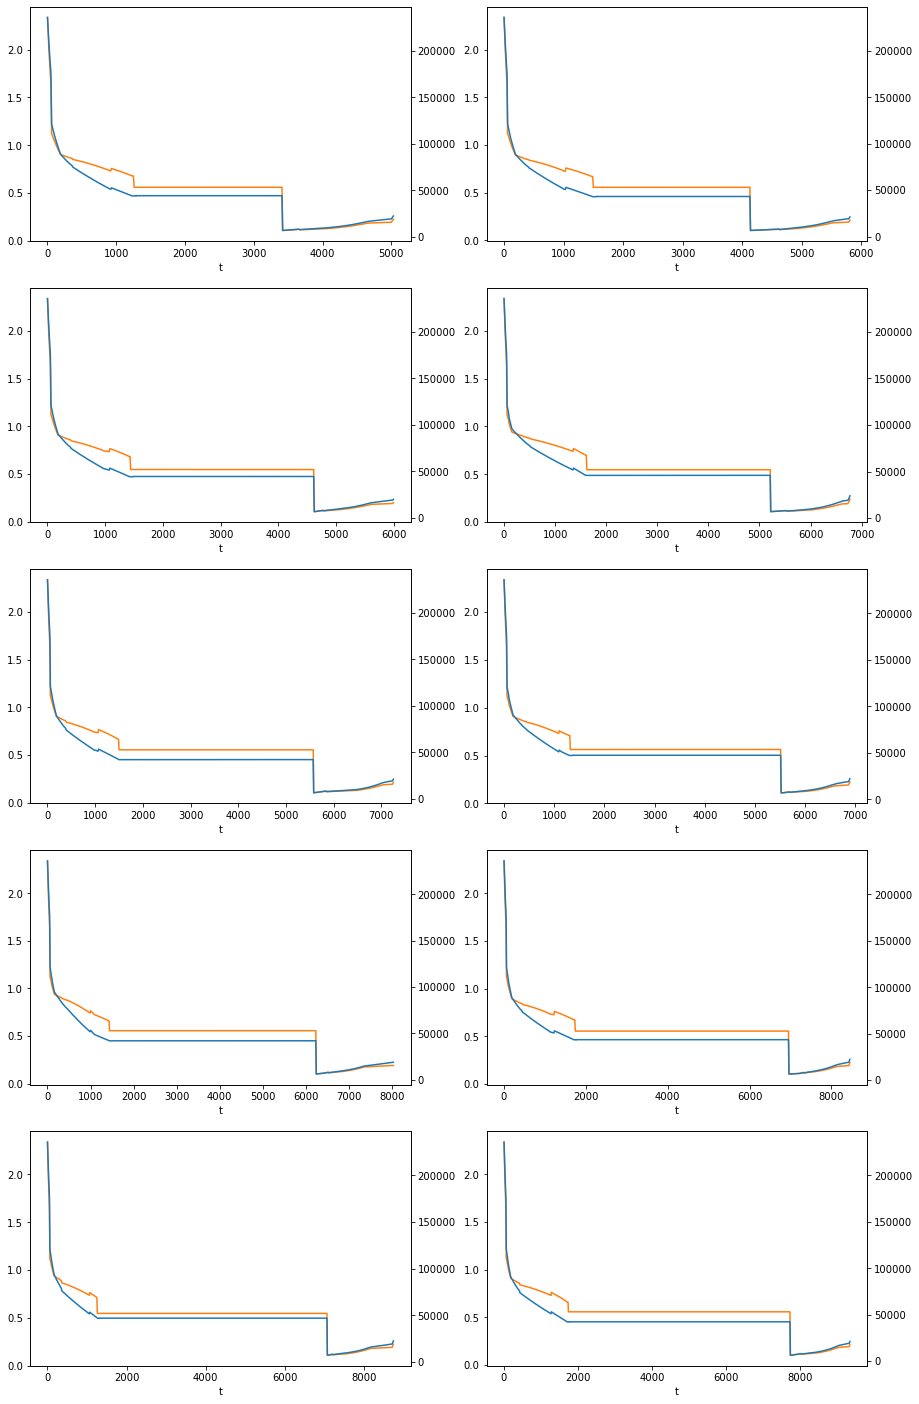

In [17]:
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
for ax, (id, traj) in zip(axes.flat, trajs.groupby("id")):
    traj.query("ff==ff").plot(
        x="t",
        y=["thr", "ff"],
        secondary_y="thr",
        ax=ax,
        legend=False,
    )

In [27]:
cumul = []
t = int(traj["t"].diff().iloc[1])
for id, traj in trajs.groupby("id"):
    traj["fc"] = (traj["ff"] * t).cumsum(skipna=True)
    cumul.append(traj)
trajs = pd.concat(cumul)
trajs

,t,h,s,v,vs,id,fp,thr,ff,fc
0,0,0.0,0.000000e+00,0.0,0.0,0,TO,235799.998186,2.337624,23.376240
1,10,0.0,0.000000e+00,19.3,0.0,0,TO,221766.340217,2.161416,44.990398
2,20,0.0,1.930000e+02,38.6,0.0,0,TO,208782.316062,2.007156,65.061956
3,30,0.0,5.790000e+02,57.9,0.0,0,TO,196847.925718,1.872074,83.782700
4,40,0.0,1.158000e+03,77.2,0.0,0,TO,185963.169187,1.753919,101.321887
...,...,...,...,...,...,...,...,...,...,...
2310,23080,0.0,4.985424e+06,59.8,0.0,38,DE,19990.563450,0.201312,12439.972378
2311,23090,0.0,4.986022e+06,47.6,0.0,38,DE,21059.163483,0.211754,12442.089923
2312,23100,0.0,4.986498e+06,35.4,0.0,38,NA,NaN,NaN,NaN
2313,23110,0.0,4.986852e+06,23.2,0.0,38,NA,NaN,NaN,NaN


In [42]:
cumul = []
for id, traj in trajs.groupby("id"):
    last_point = traj.query("fc==fc").iloc[-1]
    cumul.append((id, last_point.s, last_point.fc))
fc = pd.DataFrame.from_records(cumul, columns=["id", "fd", "fc"])

<AxesSubplot:xlabel='fd'>

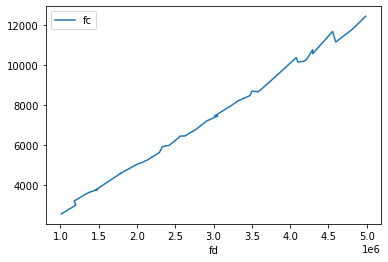

In [43]:
fc.plot(x="fd", y="fc")